# BTC Long/Short Classifier

In [77]:
# Import statements

import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

In [184]:
# Load our csv as a pandas dataframe
btc = pd.read_csv("../../Python/side-projects/btc-price-tracker-enhanced/BTCUSDT-D.csv")

In [186]:
btc = btc.drop(["time", "volume"], axis = 1)

In [228]:
# Calculate the change of yesterdays open to todays open, why we do this? because I should be able to provide the algo
# With the new days open and therefore be able to use this feature to forward classifier what may lie in the day.

close_change = [0]

for idx in range(len(btc)):

    if idx == 0:
        continue
        
    close_change.append(round((btc["open"][idx] - btc["open"][idx-1]) / btc["open"][idx-1] * 100, 2))

btc["close_change"] = close_change

In [230]:
# Create our target labels for classification

direction = []

for idx in range(len(btc)):

    if btc["close"][idx] - btc["open"][idx] > 0:
        direction.append("long")
    else:
        direction.append("short")

btc["target"] = direction

In [232]:
day = []

for row in range(len(btc)):
    day.append(btc["date"][row].split("-")[0])

btc["day"] = day

In [234]:
moving_average = []
length = 3

rolling_average = btc["close_change"].rolling(length)

for entry in rolling_average:
    total = 0
    for line in entry:
        total += line
    avg = total / len(entry)
    moving_average.append(round(avg, 2))

btc["moving_average"] = moving_average
btc.tail()

,date,open,high,low,close,close_change,target,moving_average,day,high_change,low_change
999,Tue-17-Sep-24,58185,61330,57568,60275,-1.55,long,-1.27,Tue,3.63,0.21
1000,Wed-18-Sep-24,60275,60747,59835,60231,3.59,short,0.20,Wed,-0.95,3.94
1001,Thu-19-Sep-24,61744,63856,61524,62923,2.44,long,1.49,Thu,5.12,2.82
1002,Fri-20-Sep-24,62923,64132,62310,63174,1.91,long,2.65,Fri,0.43,1.28
1003,Sat-21-Sep-24,63174,63544,62713,63312,0.40,long,1.58,Sat,-0.92,0.65


In [236]:
target = btc["target"]

target_lb = LabelEncoder()
target = target_lb.fit_transform(target)

day_lb = LabelEncoder()
btc["day"] = day_lb.fit_transform(btc["day"])

features = btc.drop(["date", "open", "high", "low", "close", "target", "day"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [238]:
sgd_clf = SGDClassifier(random_state=42)
rnd_clf = RandomForestClassifier(random_state = 42)

score = cross_val_score(rnd_clf, X_train, y_train, scoring = "f1_macro").mean()
round(score,4)

0.7487

Is it possible to use just raw price data to predict the upcoming price of bitcoin? That is the question I am looking to answer in this notebook. The plan is<br>
to try calculate features from only the date, high, low, open, close and volume for the last 1000 days of price action.

In [256]:
# Import statements

import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

In [258]:
# Load our csv as a pandas dataframe
btc = pd.read_csv("../../Python/side-projects/btc-price-tracker-enhanced/BTCUSDT-D.csv")

In [260]:
# Have a squizz at the data
btc.head()

,date,time,open,high,low,close,volume
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382


We have to clean the date column up and split the string apart to only contain the day of the week as my idea is to use that to find a potential pattern <br>
in the price. I think that month in collaboration with day of the week might be handy too but im unsure... So for now we will just try day of the week and <br>
keep months in our back pocket

## Transform the data column, creating features

#### Adding days of the week

In [265]:
# Create a list to hold the days of the week
days = []

# Iterate over each date in the data column
for date in btc["date"]:
    # Split the string on the hypphens and take the first string (The abbrivated day)
    day = date.split("-")[0]
    # append the day to the list
    days.append(day)

# Create the new column for our dataframe containing the days of the week
btc["day"] = days
btc.head()

,date,time,open,high,low,close,volume,day
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon


### Calculate features

In [268]:
# Creates a list out of a given column

def create_list(column):
    """
    Takes a pandas column and iterates over it's content appending each
    row to a list and than returns that list
    :Params: coloumn - a pandas column
    :Return: ls - a list of all values in that column
    """
    
    ls = []
    
    for row in column:
        ls.append(row)
    return ls

#### Calculating percentage change

In [271]:
# Createa list of all open values
opens = btc["open"]

# Create a list of all close values
closes = btc["close"]


# Iterate through both lists of values and calculate the change from open to close price, append it to a list
changes = [0]
for idx in range(len(opens)):
    if idx == 0:
        continue
    change = round((opens[idx - 1] - opens[idx]) / opens[idx-1] * 100, 2)
    changes.append(change)

# Add the column to the data
btc["change"] = changes
btc.head()

,date,time,open,high,low,close,volume,day,change
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu,0.00
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri,-4.49
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat,0.02
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun,0.75
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon,-0.71


#### Calculating high to low differences

In [274]:
# Creates lists for the highs and the lows
highs = create_list(btc["high"])
lows = create_list(btc["low"])

# Create two features calculating the difference between the highs and the lows and the closes
high_to_close = []
low_to_close = []
high_to_low = []
for idx in range(len(closes)):
    high_to_close.append(round((highs[idx] - closes[idx]) / closes[idx] * 100, 2))
    low_to_close.append(round((closes[idx] - lows[idx]) / closes[idx] * 100, 2))
    high_to_low.append(round((highs[idx] - lows[idx]) / highs[idx] * 100, 2))
    
# Add our new features to the dataframe
btc["high_to_close"] = high_to_close
btc["low_to_close"] = low_to_close
btc["high_to_low"] = high_to_low
btc.head()

,date,time,open,high,low,close,volume,day,change,high_to_close,low_to_close,high_to_low
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu,0.00,1.26,5.44,6.61
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri,-4.49,2.35,0.75,3.04
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat,0.02,1.47,0.61,2.05
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun,0.75,1.05,2.92,3.92
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon,-0.71,2.79,0.48,3.18


#### Adding long an short labels

In [279]:
directions = []

# Createa list of all open values
opens = btc["open"]

# Create a list of all close values
closes = btc["close"]

for idx in range(len(opens)):

    change = round((closes[idx] - opens[idx]) / opens[idx] * 100, 2)

    
    if change >= 0:
        directions.append("long")
    else: 
        directions.append("short")

btc["direction"] = directions
btc.head(45)

,date,time,open,high,low,close,volume,day,change,high_to_close,low_to_close,high_to_low,direction
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu,0.00,1.26,5.44,6.61,long
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri,-4.49,2.35,0.75,3.04,short
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat,0.02,1.47,0.61,2.05,short
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun,0.75,1.05,2.92,3.92,long
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon,-0.71,2.79,0.48,3.18,short
5,Tue-28-Dec-21,00:00:00,50706,50707,47312,47539,2875996781,Tue,0.11,6.66,0.48,6.70,short
6,Wed-29-Dec-21,00:00:00,47539,48137,45808,46450,2256915114,Wed,6.25,3.63,1.38,4.84,short
7,Thu-30-Dec-21,00:00:00,46450,47920,45887,47110,1767328940,Thu,2.29,1.72,2.60,4.24,long
8,Fri-31-Dec-21,00:00:00,47110,48554,45634,46200,2597175210,Fri,-1.42,5.10,1.23,6.01,short
9,Sat-01-Jan-22,00:00:00,46200,47916,46200,47720,1597455880,Sat,1.93,0.41,3.19,3.58,long


This time ill try with only the change, day and volume.

In [203]:
# def pipline(X_set, y_set):

X = btc.drop(["date", "time", "open", "high", "low", "close", "day", "high_to_close", "low_to_close", "high_to_low", "direction"], axis = 1)
X["days"] = days

X_train, X_test, y_train, y_test = train_test_split(X, direction)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ValueError: Found input variables with inconsistent numbers of samples: [1005, 1004]

In [205]:
rando2 = RandomForestClassifier()

score2 = cross_val_score(rando2, X_train, y_train, cv = 10, scoring = "f1_macro")
score2.mean()

1.0

Again, I smell bullshit... probably because it is 100% using change to define what to do which literally is telling it if it was an iup or down day

In [2367]:
rando2 = rando2.fit(X_train, y_train)

for name, score in zip(X.columns, rando2.feature_importances_):
    print(name, score)

volume 0.031024653677208136
change 0.9621216111007035
days 0.006853735222088388


Yeah so this line of thought is completely pointless, im going about everything wrong, or this just isn't possible doing it the way I am doing it. I wish I could get it to classifier<br>
a percent up or down, but that also makes no sense... None of this makes sense, and I know that, I was just trying to see what I could squeeze out of price only... silly idea.

Ok I will try one last thing..., it makes no sense, but I will make the changes the labels and use the days to predict.... wild idea I know... I must exhust everything so I stop<br>
thinking that I have missed something

In [2371]:
X = btc.drop(["date", "time", "open", "high", "low", "close", "day", "change", "high_to_close", "low_to_close", "high_to_low", "direction"], axis = 1)
X["days"] = days
y = [int(i) for i in btc.change]

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [2372]:
rando2 = RandomForestClassifier()

score2 = cross_val_score(rando2, X_train, y_train, cv = 10, scoring = "f1_macro")
score2.mean()



/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0.06821771749499314

That is hilarious.... 6% hitrate... gonna need some tight risk management to pull this stategy off.... I need to go back to the drawing board and think of some external features <br>
to add, or some lagging indicators with price that has a shot of forward predicting the price if im to continue with this project as it is.

In [2374]:
btc.head()

,date,time,open,high,low,close,volume,day,change,high_to_close,low_to_close,high_to_low,direction
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu,4.49,1.26,5.44,6.61,long
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri,-0.02,2.35,0.75,3.04,short
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat,-0.75,1.47,0.61,2.05,short
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun,0.71,1.05,2.92,3.92,long
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon,-0.11,2.79,0.48,3.18,short


In [2375]:
month = []

for row in btc["date"]:
    month.append(row.split("-")[2])


In [2376]:
month_encoder = LabelEncoder()
month = month_encoder.fit_transform(month)
btc["month"] = month

In [2380]:
X = btc.drop(["date", "time", "open", "high", "low", "close", "day", "change", "high_to_close", "low_to_close", "high_to_low", "direction"], axis = 1)
X["days"] = days
y = [int(i) for i in btc.change]

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [2381]:
rando4 = RandomForestClassifier()

score4 = cross_val_score(rando4, X_train, y_train, cv = 10, scoring = "f1_macro")
score4.mean()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0.0562795246074686

Ok sorry, had to try adding in months and seeing what happens... what does it value btw?

In [2384]:
rando4 = rando4.fit(X_train, y_train)

for name, score in zip(X.columns, rando4.feature_importances_):
    print(name, score)

volume 0.6892722101674161
month 0.19110734555752915
days 0.11962044427505474


In [281]:
def rolling_avg(column, length):
    """
    Calculates the moving average of length (length) on the series (column) passed
    into the function
    Params
    column - the string name of a pandas column from your dataset
    length - an int the length of the moving average
    """
    rolling_avg = btc[column].rolling(length)

    change_avgs = []

    for line in rolling_avg:
        tot = 0
        for l in line:
            tot += l
        avg = tot / len(line)
        change_avgs.append(round(avg,6))

    # change_avgs.pop(len(change_avgs)-1)
    return change_avgs


In [283]:
def augment_columns(column):
    ls_changes = [0]
    
    for change in btc[column]:
        ls_changes.append(change)
    
    ls_changes.pop(len(ls_changes)-1)
    return ls_changes

In [285]:
# Creating a smaller dataframe out of only a few features to test some ideas on
btc_features = btc.drop(["date", "time", "open", "high", "low", "close"], axis = 1)
btc_features.head()

,volume,day,change,high_to_close,low_to_close,high_to_low,direction
0,2246508966,Thu,0.00,1.26,5.44,6.61,long
1,1837726929,Fri,-4.49,2.35,0.75,3.04,short
2,1147589024,Sat,0.02,1.47,0.61,2.05,short
3,1676805639,Sun,0.75,1.05,2.92,3.92,long
4,1765283382,Mon,-0.71,2.79,0.48,3.18,short


In [287]:
# Transform our days using a labelencoder
day_encoder = LabelEncoder()
days = day_encoder.fit_transform(btc_features["day"])

direction_encoder = LabelEncoder()
direction = direction_encoder.fit_transform(btc_features["direction"])
# dir_encoder.classes_

# Check it was transformed into an array by proxy of data scaling
# X_train

In [335]:
# Create a new Dataframe for attempt ∞
X = pd.DataFrame()

# Add days as a column in our dataframe
# X["days"] = days

# Assign short and long lengths for moving averages
short_length = 2
long_length = 2

# Add moving averages to our dataframe
X["chang_avg_short"] = rolling_avg("change", short_length)
# X["high_avg_short"] = rolling_avg("high_to_close",short_length)
# X["low_avg_short"] = rolling_avg("low_to_close",short_length)
# X["mag_avg_short"] = rolling_avg("high_to_low",short_length)

# X["chang_avg_long"] = rolling_avg("change",long_length)
# X["high_avg_long"] = rolling_avg("high_to_close",long_length)
# X["low_avg_long"] = rolling_avg("low_to_close",long_length)
# X["mag_avg_long"] = rolling_avg("high_to_low",long_length)

# Add the augmented versions of high, low, change, aguemented by one day, therefore they are the previous days values
# X["new_changes"] = augment_columns("change")
# X["new_highs"] = augment_columns("high_to_close")
# X["new_lows"] = augment_columns("low_to_close")

X["new_changes"] = btc["change"]

# Inspect what we have done
X.head()

,chang_avg_short,new_changes
0,48610.0,0.00
1,49702.0,-4.49
2,50789.5,0.02
3,50595.5,0.75
4,50584.5,-0.71


In [337]:
# Split the data for training
X_train, X_test, y_train, y_test = train_test_split(X, direction, random_state = 42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [339]:
### Create a randomForest and validate it's score
# rnd_clf = RandomForestClassifier(random_state = 42)

# rnd_clf_score = cross_val_score(rnd_clf, X_train, y_train, cv = 10, scoring = "f1_macro")
# print(rnd_clf_score.mean())

# ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 200, algorithm="SAMME.R", learning_rate=0.5)

# ada_clf_score = cross_val_score(ada_clf, X_train, y_train, cv = 10, scoring = "f1_macro")
# print(ada_clf_score.mean())

# gbc_clf = GradientBoostingClassifier(max_depth = 2, n_estimators = 3, learning_rate = 1.0)

# gbc_clf_score = cross_val_score(gbc_clf, X_train, y_train, cv = 10, scoring = "f1_macro")
# print(gbc_clf_score.mean())

sgd_clf = SGDClassifier(alpha=0.01, tol=0.001,random_state=42)

sgd_clf_score = cross_val_score(sgd_clf, X_train, y_train, cv = 10, scoring = "accuracy")
print(sgd_clf_score.mean())

0.513982456140351


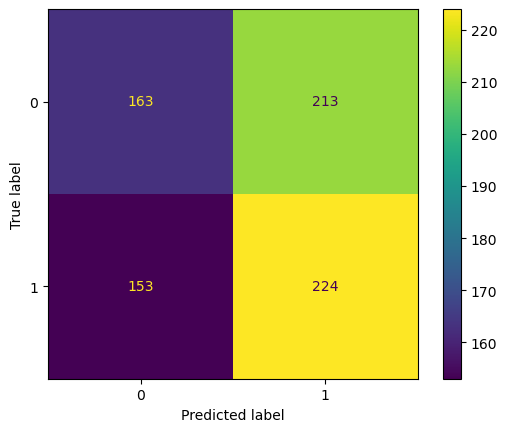

In [341]:
# rnd_clf.fit(X_train, y_train)
# y_pred = rnd_clf.predict(X_test)
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

sgd_clf.fit(X_train, y_train)
y_pred = cross_val_predict(sgd_clf, X_train, y_train, cv = 10)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred)

In [343]:
print(X.tail())
btc.tail(7)

      chang_avg_short  new_changes
999           58643.0         1.55
1000          59230.0        -3.59
1001          61009.5        -2.44
1002          62333.5        -1.91
1003          63048.5        -0.40


,date,time,open,high,low,close,volume,day,change,high_to_close,low_to_close,high_to_low,direction
997,Sun-15-Sep-24,00:00:00,59968,60393,58652,59101,3763712483,Sun,0.82,2.19,0.76,2.88,short
998,Mon-16-Sep-24,00:00:00,59101,59182,57450,58185,7324801553,Mon,1.45,1.71,1.26,2.93,short
999,Tue-17-Sep-24,00:00:00,58185,61330,57568,60275,9513245410,Tue,1.55,1.75,4.49,6.13,long
1000,Wed-18-Sep-24,00:00:00,60275,60747,59835,60231,1349677844,Wed,-3.59,0.86,0.66,1.50,short
1001,Thu-19-Sep-24,00:00:00,61744,63856,61524,62923,9254066053,Thu,-2.44,1.48,2.22,3.65,long
1002,Fri-20-Sep-24,00:00:00,62923,64132,62310,63174,7482991678,Fri,-1.91,1.52,1.37,2.84,long
1003,Sat-21-Sep-24,00:00:00,63174,63544,62713,63312,2179629210,Sat,-0.40,0.37,0.95,1.31,long


In [345]:

# Percent change is taking the moving average for a longer period than what is being used as a feature in the classifier
# and inputing it as one of the parameters for predictioin. The reason we need this is because this sgd model is using
# The last three day moving average as a feature yet we dont have the current days % change moving average until the day
# ends, therefore we need to source a different average that should be close to the 3 day, but more general as to add as
# little bias as possible to the predict.... that's what this is.
percent_change = rolling_avg("change",long_length)[len(rolling_avg("change",long_length))-1]
print(percent_change)
# Predicting the current days market direction, first parameter explained above, second is what the daily closed the morning 
# of this day.
trade = sgd_clf.predict([[percent_change, -0.4]])

trade = direction_encoder.classes_[trade[0]]
# day_encoder.classes_
trade

-1.155


'short'

In [347]:
# Calculate a 7 day avg of change and try classify on that
# Figure out a way to make a regressor that we put in a pervious days or weeks set of details or avgs 
# and have it output a prediction on % change the next day

In [349]:
# rnd_clf = rnd_clf.fit(X_train, y_train)

# for name, score in zip(X.columns, rnd_clf.feature_importances_):
#     print(name, score)

In [351]:
# Figures out what the trade for the day is

high = rolling_avg("high_to_close",short_length)
low = rolling_avg("low_to_close",short_length)

high = high[len(high)-1]
low = low[len(low)-1]

target = 0
stop = 0
entry = btc["close"][len(btc)-1]
if trade == "long":
    target = high /100 * entry + entry
    stop = entry - (low /100 * entry)
else:
    target = entry - (low /100 * entry)
    stop = high /100 * entry + entry

print(f"Today's trade is a {trade} with an entry at {entry} a stop at {round(stop)} and a target of {round(target)}")

Today's trade is a short with an entry at 63312 a stop at 63910 and a target of 62578


This is kinda at a point where I either build a bot to execute trades on it or bin this plan and go do some neural network stuff for this problem

In [354]:
X["chang_avg_long"] = rolling_avg("change",long_length)
X["direction"] = direction
X["date"] = btc["date"]
X

,chang_avg_short,new_changes,chang_avg_long,direction,date
0,48610.0,0.00,0.000,0,Thu-23-Dec-21
1,49702.0,-4.49,-2.245,1,Fri-24-Dec-21
2,50789.5,0.02,-2.235,1,Sat-25-Dec-21
3,50595.5,0.75,0.385,0,Sun-26-Dec-21
4,50584.5,-0.71,0.020,1,Mon-27-Dec-21
...,...,...,...,...,...
999,58643.0,1.55,1.500,0,Tue-17-Sep-24
1000,59230.0,-3.59,-1.020,1,Wed-18-Sep-24
1001,61009.5,-2.44,-3.015,0,Thu-19-Sep-24
1002,62333.5,-1.91,-2.175,0,Fri-20-Sep-24


In [356]:
correct = 0
all = 0
for row in range(len(X)):
    prediction = sgd_clf.predict([[X["chang_avg_long"][row], btc["change"][row]]])
    print(X["date"][row], direction_encoder.classes_[prediction[0]], btc["change"][row])
    if prediction[0] == X["direction"][row]:
        correct += 1
    all += 1


print(all, correct)

Thu-23-Dec-21 short 0.0
Fri-24-Dec-21 short -4.49
Sat-25-Dec-21 short 0.02
Sun-26-Dec-21 long 0.75
Mon-27-Dec-21 short -0.71
Tue-28-Dec-21 short 0.11
Wed-29-Dec-21 long 6.25
Thu-30-Dec-21 long 2.29
Fri-31-Dec-21 short -1.42
Sat-01-Jan-22 long 1.93
Sun-02-Jan-22 short -3.29
Mon-03-Jan-22 long 0.87
Tue-04-Jan-22 long 1.78
Wed-05-Jan-22 long 1.27
Thu-06-Jan-22 long 5.3
Fri-07-Jan-22 long 0.75
Sat-08-Jan-22 long 3.61
Sun-09-Jan-22 short -0.33
Mon-10-Jan-22 short -0.4
Tue-11-Jan-22 short 0.11
Wed-12-Jan-22 short -2.14
Thu-13-Jan-22 short -2.78
Fri-14-Jan-22 long 3.02
Sat-15-Jan-22 short -1.16
Sun-16-Jan-22 short -0.06
Mon-17-Jan-22 short 0.07
Tue-18-Jan-22 long 1.98
Wed-19-Jan-22 short -0.31
Thu-20-Jan-22 long 1.53
Fri-21-Jan-22 long 2.36
Sat-22-Jan-22 long 10.47
Sun-23-Jan-22 long 3.79
Mon-24-Jan-22 short -3.34
Tue-25-Jan-22 short -1.15
Wed-26-Jan-22 short -0.78
Thu-27-Jan-22 long 0.45
Fri-28-Jan-22 short -1.01
Sat-29-Jan-22 short -1.49
Sun-30-Jan-22 short -1.21
Mon-31-Jan-22 long 0.72
Tue

Ok this little experiment kinda put the nail in the coffin.... right now it is meant to have 74% accuracy, but when calling predict on the entire set and<br>
passing in what would be the correct second parameter of the next days change % and the first parameter of a slightly longer caalculated average of change<br>
we only are able to get 163  out of 1000 trades right... 16% is not good at all and something doesn't seem right for a classifier that can get 75% f1_score? <br>
fuck this, im gonna go learn more complicated stuff so I can make even bigger errors and waste even more time!